## Exercise Notebook

This notebook provides some rough markdown comment guidelines for you to program your own invariant/equivariant NN.
Let's get started!

First, we have to import all the relevant packages.<br>
Just come back and add what's missing!

In [1]:
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from ase.io import read
from ase.neighborlist import neighbor_list
# from torch_scatter import scatter_add,scatter_sum
from typing import List 
from e3nn import o3
from e3nn.nn import Activation, Gate

In [2]:
from typing import Optional


def broadcast(src: torch.Tensor, other: torch.Tensor, dim: int):
    if dim < 0:
        dim = other.dim() + dim
    if src.dim() == 1:
        for _ in range(0, dim):
            src = src.unsqueeze(0)
    for _ in range(src.dim(), other.dim()):
        src = src.unsqueeze(-1)
    src = src.expand(other.size())
    return src

def scatter_sum(src: torch.Tensor,
                index: torch.Tensor,
                dim: int = -1,
                out: Optional[torch.Tensor] = None,
                dim_size: Optional[int] = None) -> torch.Tensor:
    index = broadcast(index, src, dim)
    if out is None:
        size = list(src.size())
        if dim_size is not None:
            size[dim] = dim_size
        elif index.numel() == 0:
            size[dim] = 0
        else:
            size[dim] = int(index.max()) + 1
        out = torch.zeros(size, dtype=src.dtype, device=src.device)
        return out.scatter_add_(dim, index, src)
    else:
        return out.scatter_add_(dim, index, src)


def scatter_add(src: torch.Tensor,
                index: torch.Tensor,
                dim: int = -1,
                out: Optional[torch.Tensor] = None,
                dim_size: Optional[int] = None) -> torch.Tensor:
    return scatter_sum(src, index, dim, out, dim_size)



**Molecular Graph Representation**


Let's begin by defining an object containing the relevant graph information, derived from an ASE atoms object.

We define a lightweight wrapper class that extracts geometric and chemical information from an ASE atoms object.
<br> <br>

<details>
<summary> <strong> Hint </strong> (click me) </summary>

Define some `__init__`, taking the `ase.atoms`-object, and a function to build a neighbour list.
- Stores atomic positions and element types
- Builds a neighbor list using ASE (with periodicity and cutoff)
- Computes normalized direction vectors for atom pairs
- Encodes element types as consecutive indices (not atomic numbers)
</details>

<br> 

<details>
<summary> <strong> Neighbor list hint </strong> (click me) </summary>
You can use ase neighbor list as this
```
from ase.neighborlist import neighbor_list
idx_i, idx_j, d_ij, r_ij, S = neighbor_list("ijdDS",at,cutoff=cutoff,self_interaction=False)
```
- Encodes element types as consecutive indices (not atomic numbers)
</details>


In [3]:
class TorchAtoms():
    def __init__(self,aseAtoms):
        '''
        Simple class containing molecular graph information based on an atoms object
        '''
        self.ase_mol = aseAtoms.copy()
        self.xyz = torch.tensor(aseAtoms.get_positions())
        self._build_neighbor_list()
        self.elements = list(set(self.ase_mol.symbols))
        self.n_elements = len(self.elements)
        self.element_labels = torch.tensor([self.elements.index(sym) for sym in self.ase_mol.symbols]) # Elements are labeled consecutively not by atomic number (to match the index of the embedding)
        self.n_atoms = len(aseAtoms)
        
    def _build_neighbor_list(self, cutoff=3.0):
        at = self.ase_mol.copy()
        at.center(vacuum=10)
        idx_i, idx_j, d_ij, r_ij, S = neighbor_list("ijdDS",at,cutoff=cutoff,self_interaction=False)
        self.idx_i = torch.from_numpy(idx_i)
        self.idx_j = torch.from_numpy(idx_j)
        self.d_ij  = torch.from_numpy(d_ij).type(torch.FloatTensor)
        self.r_ij  = torch.from_numpy(r_ij).type(torch.FloatTensor)
        self.dir_ij = F.normalize(self.r_ij,p=2,dim = 1)


**Mini-batching multiple molecular systems**

For later usage, let's also already predefine a batched version of our `TorchAtoms`, where we concanate relevant tensors.

Define a container that merges several `TorchAtoms` objects into a single batched structure.

Another option is to use dataloader from `torch`, however for our simple case it is not fully needed
<br><br>


<details>
<summary><strong> Hint </strong></summary>

Each molecule has its own local atom indexing. To combine them into one large graph, indices must be shifted so they don’t overlap.
    
- Atom indices are adjusted via per-molecule offsets.
- Neighbor and feature tensors are concatenated across molecules.
- Each atom is tagged with a `mol_id` for later aggregation per system.


</details>


In [4]:
class BatchedTorchAtoms():
    def __init__(self, 
                 mol_list: List[TorchAtoms]):
        offsets = []
        cum = 0
        for mol in mol_list:
            offsets.append(cum)
            cum += mol.n_atoms
        self.n_mols = len(mol_list)
        self.idx_i = torch.cat([m.idx_i + off for m, off in zip(mol_list, offsets)])
        self.idx_j = torch.cat([m.idx_j + off for m, off in zip(mol_list, offsets)])
        self.d_ij  = torch.cat([m.d_ij  for m in mol_list])
        self.r_ij  = torch.cat([m.r_ij  for m in mol_list])
        self.dir_ij = torch.cat([m.dir_ij for m in mol_list])
        self.element_labels = torch.cat([m.element_labels for m in mol_list])
        self.n_elements = torch.unique(self.element_labels).numel() 
        mol_ids = [ #This generates indexes of which atom belong to which system
            torch.full((m.n_atoms,), idx, dtype=torch.long) 
            for idx, m in enumerate(mol_list)
        ]
        self.mol_id = torch.cat(mol_ids)

**Load and preprocess data**

And load and prep objects of classes. Here we are providing data of water clusters calculated with FHI-aims on PBE0 level.

We read a set of molecular structures (here: water clusters) and convert them into graph-based representations.

<details>
<summary><strong> Hint</strong></summary>

This ASE syntax selects the first 10 configurations from a trajectory-style `.xyz` file.
    
- The `.xyz` file contains multiple frames; only the first 10 are read.
- Each structure is wrapped as a `TorchAtoms` object.
- A batched container combines all systems for model input.

</details>

**Extract graph features**

Then, retrieve atomic types, pairwise distances, directions, and neighbor indices from the batched data.

In [5]:
mols = read("waterAims.xyz@:10",format="extxyz")
torch_mols = [TorchAtoms(mol) for mol in mols]
batched_mols = BatchedTorchAtoms(torch_mols)

In [6]:
species_types = batched_mols.element_labels
r_ij   = batched_mols.r_ij
d_ij   = batched_mols.d_ij
dir_ij = batched_mols.dir_ij
idx_i  = batched_mols.idx_i
idx_j  = batched_mols.idx_j

Each ase.atoms obejct has following info and arrays. The important bits will be `dft_dipole` and `dft_hirshfeld`

In [7]:
print([k for k in mols[0].info])
print([k for k in mols[0].arrays])

['dft_energy', 'dft_dipole']
['numbers', 'positions', 'dft_forces', 'dft_hirshfeld']


As long as we will do a one-batch training, the code will be the same, so feel free to use `batched_mols` or `[torch_mols[0]]` in your code

# Invariant NN - SchNet

**Atom-type embeddings**

The first step towards building the atomic representations is to match each element to a vector of dimension `n_features` via a so called embedding (basically just an optimizable look-up table).

Now, map discrete atomic species to continuous feature vectors using a learnable embedding layer.
<br><br>
<details>
<summary><strong> Hint</strong></summary>

An `nn.Embedding` turns integer-labeled types into dense vectors that can be optimized during training.  
This is analogous to word embeddings in NLP, but here used for element types.

</details>

In [8]:
n_elements = batched_mols.n_elements
species_types = batched_mols.element_labels
feature_dimension = 16
element_embedding = nn.Embedding(n_elements, feature_dimension)
node_embeddings = element_embedding(species_types)
print(node_embeddings)
print(node_embeddings.shape)

tensor([[-0.0109,  0.4197, -0.1325,  ...,  0.5523, -0.9241, -1.6046],
        [-1.4363,  1.1540,  0.8700,  ..., -0.6151,  0.4054,  0.2882],
        [-1.4363,  1.1540,  0.8700,  ..., -0.6151,  0.4054,  0.2882],
        ...,
        [-0.0109,  0.4197, -0.1325,  ...,  0.5523, -0.9241, -1.6046],
        [-1.4363,  1.1540,  0.8700,  ..., -0.6151,  0.4054,  0.2882],
        [-1.4363,  1.1540,  0.8700,  ..., -0.6151,  0.4054,  0.2882]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([240, 16])


**Edge features via radial basis functions**

Next, we do the same thing with the edges of our graph (i.e. interatomic distances). Here we use some kind of radial basis functions (e.g. evenly spaced Gaussians).

Code a class in order to project pairwise distances onto a fixed set of radial basis functions (RBFs), implemented as Gaussians.
<br><br>
<details>
<summary><strong> Hint</strong></summary>

Distances are continuous values. To represent them as input features, we expand them in a smooth basis (here: Gaussians)  
centered along the range of expected distances. This helps the model capture distance-dependent interactions.
Define a `__init__`-function for the class being a child of `nn.Modul`, and provide a `forward` method.
</details>

In [9]:
class SimpleRBF(nn.Module):
    def __init__(self, n_rbf, cutoff, start=0.0):
        super().__init__()
        offset = torch.linspace(start, cutoff, n_rbf)
        width  = torch.abs(offset[1] - offset[0])
        self.n_rbf = n_rbf
        self.register_buffer("offset", offset)
        self.register_buffer("widths", torch.full_like(offset, width))

    def forward(self, d_ij):
        return torch.exp(-((d_ij.unsqueeze(-1) - self.offset) ** 2) / self.widths)


**Encode edge distances**

Apply the newly coded RBF expansion to pairwise distances to obtain edge features.

<details>
<summary><strong>Hint</strong></summary>

Each edge gets a feature vector of length `n_rbf`.

</details>

In [10]:
d_ij = batched_mols.d_ij
d_ij.shape
# d_ij = torch_mols[0].d_ij
# d_ij.shape

torch.Size([1558])

In [11]:
n_rbf = 10
cutoff = 3.0
RBF = SimpleRBF(n_rbf,cutoff)
edge_embeddings = RBF(d_ij)

print(edge_embeddings.shape)
print(edge_embeddings)

torch.Size([1558, 10])
tensor([[2.1320e-10, 3.5522e-08, 3.0386e-06,  ..., 6.3189e-01, 9.9001e-01,
         7.9637e-01],
        [6.0783e-02, 3.0076e-01, 7.6406e-01,  ..., 3.6706e-03, 1.7079e-04,
         4.0801e-06],
        [6.0807e-02, 3.0084e-01, 7.6416e-01,  ..., 3.6685e-03, 1.7067e-04,
         4.0766e-06],
        ...,
        [2.8709e-05, 8.6100e-04, 1.3258e-02,  ..., 5.2095e-01, 1.4692e-01,
         2.1273e-02],
        [2.4658e-12, 6.9155e-10, 9.9578e-08,  ..., 2.7984e-01, 7.3803e-01,
         9.9931e-01],
        [8.1910e-04, 1.2749e-02, 1.0189e-01,  ..., 1.5077e-01, 2.2068e-02,
         1.6584e-03]])


**Invariant Convolution**

Finally, we need to define a module that allows us to couple the representations of the atoms (nodes) via the edges. To this end we can define a simple invariant convolution, based on the continuous filter convolution in SchNet. This works by projecting both edge and node embeddings to a common latent space (of dimension `filter_dimension`) and then computing a weighted sum over the neighboring atoms j as the message to atom i.

We are going to use following equations:

First since a lenght features of our vector are not equel to a lenght of our filter, we have to do simple linear (=dense) layer to expand feature vector into the feature filter (size of the embedding `feature_dimension`) input shape (`filter_dimension`)

Convolution:
$$
\mathbf{x}_i^{l+1}  = \sum_{j=0}^{n_\text{atoms}} \mathbf{x}_j^l \circ \mathbf{R}^l(\mathbf{r}_j - \mathbf{r}_i)
$$
where R is the convolution filter generated via MLP from RBFs.
<br><br>
<details>
<summary><strong>Hint</strong></summary>
What does this convolution actually do?

This operation lets atoms exchange information with their neighbors, modulated by the distance-based filter.  
The edge-dependent filter `R_ij` is constructed from the RBF features and scaled by the sender node embedding.

The final output updates each node’s feature by aggregating messages from its neighbors, preserving rotational invariance.

</details>
<br>
<details>
<summary><strong>Hint</strong></summary>

Why `scatter_add`?

We compute messages for each edge (from `j` to `i`),  
then sum them per receiving atom `i` to get the new node representation.

</details>

In [12]:
class InvariantConvolution(nn.Module):
    def __init__(self, 
                 feature_dimension, 
                 edge_dimension, 
                 filter_dimension, 
                 activation=F.silu):
        super(InvariantConvolution, self).__init__()
        self.node2filter = nn.Linear(feature_dimension, filter_dimension)
        self.edge2filter = nn.Linear(edge_dimension, filter_dimension)
        self.filter2out  = nn.Linear(filter_dimension, feature_dimension)
        self.act = activation
   
    def forward(self,
                x,
                e_ij,
                idx_i,
                idx_j):
        x = self.act(self.node2filter(x))
        Rij = self.act(self.edge2filter(e_ij))
        x_j = x[idx_j]
        x_ij = x_j*Rij
        x = scatter_add(x_ij, idx_i, dim=0)
        x = self.filter2out(x)
        return x

Now, set a `filter_dimension` and call the newly coded Invariant Convolution, and take a look at the output's shape.

In [13]:
filter_dimension = 32
inv_conv = InvariantConvolution(feature_dimension,n_rbf,filter_dimension)
out = inv_conv(node_embeddings,edge_embeddings,idx_i,idx_j)
print(out.shape)

torch.Size([240, 16])


**Full invariant message passing model `InvNet`**

Now we can put everything together. 

Define a simple neural network that learns atomic representations via message passing based on rotationally invariant convolutions.
<br><br>
<details>
<summary><strong>Hint</strong></summary>

The model:

- embeds element types into feature vectors
- expands interatomic distances via radial basis functions
- updates node features through multiple invariant interaction blocks
- outputs per-atom scalar predictions via a readout layer

</details>
<br>
<details>
<summary><strong>Hint</strong></summary>
What’s returned here?
    
The output is one scalar per atom. Later steps might aggregate these to get molecular properties.
</details>

In [14]:
class InvNet(nn.Module):
    """
    A simple SO3-invariant representation 
    """
    def __init__(
        self,
        feature_dimension,
        filter_dimension,
        n_interactions, 
        radial_basis,
        n_elements, 
        activation = F.silu
    ):
        """
        Args:
            feature_dimension: number of features to describe atomic environments.
                This determines the size of each embedding vector; i.e. embeddings_dim.
            n_interactions: number of interaction blocks.
            lmax: maximum angular momentum of spherical harmonics basis
            radial_basis: layer for expanding interatomic distances in a basis set
            activation:
        """
        super(InvNet, self).__init__()

        self.feature_dimension = feature_dimension
        self.filter_dimension = filter_dimension
        self.n_interactions = n_interactions
        self.radial_basis = radial_basis
        self.edge_dimension = radial_basis.n_rbf
        self.activation = activation
        
        # initialize embeddings
        self.embedding = nn.Embedding(n_elements, feature_dimension)

        # initialize linear mixing layers
        self.linear = nn.Linear(feature_dimension, feature_dimension, bias=False)

        # initialize invariant convolution
        self.invconv  = InvariantConvolution(self.feature_dimension,
                                             self.edge_dimension,
                                             self.filter_dimension)
        # initialize atomic readout
        self.atomic_readout = nn.Linear(feature_dimension,1)
        

    def forward(self, inputs: BatchedTorchAtoms):
        """
        Compute atomic representations/embeddings.

        Args:
            inputs (dict of torch.Tensor): torchAtoms with input tensors.

        Returns:
            torch.Tensor: atom-wise representation.
        """
        # get tensors from input 
        species_types = inputs.element_labels
        r_ij = inputs.r_ij
        d_ij = inputs.d_ij
        dir_ij = inputs.dir_ij
        idx_i = inputs.idx_i
        idx_j = inputs.idx_j

        # Radial embedding
        e_ij = self.radial_basis(d_ij)

        # Node embedding
        x = self.embedding(species_types)

        for t in range(self.n_interactions):
            dx = self.invconv(x, e_ij, idx_i, idx_j)
            x = x + dx

        x = self.atomic_readout(x)
        return x

**Model initialization**

Set the hyperparameters and instantiate your invariant message passing model.
<br><br>
<details>
<summary><strong> Hint </strong></summary>

Keep in mind:
- Only two element types (likely H and O) are present in the water cluster dataset (`n_elements`)
- set dimensions, `rbf` and `cutoff`$\ldots$

</details>


In [15]:
feat_dim = 16
filt_dim = 32
n_rbf = 10
cutoff = 3.0
model = InvNet(
    feat_dim, 
    filt_dim, 
    n_interactions=3,
    radial_basis=SimpleRBF(n_rbf, cutoff),
    n_elements=2,
)

**Load reference labels**

*CHARGE!*

Extract the (DFT) Hirshfeld charges as training targets for each atom.
<br><br>
<details>
<summary><strong> Hint</strong></summary>

- Read the `.xyz` and use some class defined in the very beginning regarding `atoms`-objects$\ldots$
- Fill a list with the targets
- Ensures the target tensor has shape `[N, 1]` to match the model output and support broadcasting.

</details>

In [16]:
mols = read("waterAims.xyz@:10",format="extxyz")
torch_mols = [TorchAtoms(mol) for mol in mols]
batched_mols = BatchedTorchAtoms(torch_mols)

In [17]:
ref_charges = []
# print(mols[0].info
for mol in mols:
    ref_charges.extend(mol.arrays["dft_hirshfeld"])
ref_charges = torch.tensor(ref_charges,dtype=torch.float32).unsqueeze(-1) # unsqueeze for a proper shape as from torch-scatter
print(ref_charges.shape)

torch.Size([240, 1])


**Training loop**

*No Pain, no gain!*

Train the model to predict atomic charges via mean squared error loss.
<br><br>
<details>
<summary><strong>Hint</strong></summary>

This simple example does not use dropout or batchnorm.
Simply build a `for`-loop for the training.
Define:
- `n_epochs`
- and optimizer
- don't forget your model and loss
- what do you have to call regarding the `grad` when in training ?
- *optional but recommended: some tracking (e.g. every 10th epoch print epoch and loss)*
</details>


In [18]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
n_epochs = 1000
for epoch in range(n_epochs):
    #model.train()
    q     = model(batched_mols)
    loss  = F.mse_loss(q, ref_charges)
    # if epoch%10==0:
        # print(f"# {epoch:5} charges: {q.T}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"# {epoch:5} total loss: {loss.item():.6f}")


#     0 total loss: 0.147545
#    10 total loss: 0.030945
#    20 total loss: 0.016386
#    30 total loss: 0.008683
#    40 total loss: 0.005853
#    50 total loss: 0.004378
#    60 total loss: 0.003280
#    70 total loss: 0.002561
#    80 total loss: 0.002095
#    90 total loss: 0.001797
#   100 total loss: 0.001606
#   110 total loss: 0.001470
#   120 total loss: 0.001361
#   130 total loss: 0.001264
#   140 total loss: 0.001175
#   150 total loss: 0.001092
#   160 total loss: 0.001013
#   170 total loss: 0.000939
#   180 total loss: 0.000868
#   190 total loss: 0.000801
#   200 total loss: 0.000736
#   210 total loss: 0.000674
#   220 total loss: 0.000614
#   230 total loss: 0.000558
#   240 total loss: 0.000504
#   250 total loss: 0.000452
#   260 total loss: 0.000405
#   270 total loss: 0.000361
#   280 total loss: 0.000320
#   290 total loss: 0.000284
#   300 total loss: 0.000252
#   310 total loss: 0.000224
#   320 total loss: 0.000199
#   330 total loss: 0.000178
#   340 total 

**Prediction vs. reference**

Compare predicted atomic charges to DFT reference using a scatter plot.
<br><br>
<details>
<summary><strong>Hint:</strong> What would perfect predictions look like?</summary>

All points lie on the diagonal: predicted charge = reference charge.<br>
*Optional:* add this diagonal as visual reference.
</details>


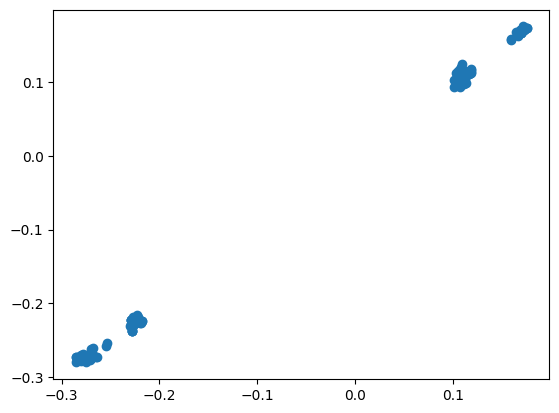

In [19]:
q = model(batched_mols)
import matplotlib.pyplot as plt
plt.scatter(ref_charges.detach().numpy(),q.detach().numpy())


### Optional: Larger Model

**Rerun with larger model**

Increase model capacity by using more features, interactions, and wider RBF coverage.

In [20]:
feat_dim = 64
filt_dim = 120
n_rbf = 20
cutoff = 6.0
model = InvNet(
    feat_dim, 
    filt_dim, 
    n_interactions=6,
    radial_basis=SimpleRBF(n_rbf, cutoff),
    n_elements=2,
)

**Create batches**

Split dataset into batches of 10 molecules and collect reference charges per batch.


In [21]:
mols = read("waterAims.xyz@:50",format="extxyz")
# torch_mols = [TorchAtoms(mol) for mol in mols]
# batches = [BatchedTorchAtoms(torch_mols[x:x+5]) for x in range(len(torch_mols))]
# batched_mols = BatchedTorchAtoms(torch_mols)
ref_charges = []
batches = []
for id_some_mols in range(0,len(mols),10):
    tmp_batch = []
    tmp_charges = []
    for mol in mols[id_some_mols:id_some_mols+10]:
        tmp_charges.extend(mol.arrays["dft_hirshfeld"])
        tmp_batch.append(TorchAtoms(mol))
    batches.append(BatchedTorchAtoms(tmp_batch))
    tmp_charges = torch.tensor(tmp_charges,dtype=torch.float32).unsqueeze(-1) # unsqueeze for a proper shape as from torch-scatter
    ref_charges.append(tmp_charges)
# print(ref_charges.shape)


In [22]:
print(len(batches))

5


In [23]:
for a in batches:
    print(a.d_ij[:10])

tensor([2.7245, 0.9662, 0.9661, 2.8531, 1.7603, 2.8621, 1.5403, 2.6572, 0.9661,
        2.2314])
tensor([2.8691, 0.9537, 1.9271, 2.8689, 1.9145, 0.9726, 2.7467, 2.6324, 2.6279,
        1.5457])
tensor([1.8531, 2.9247, 0.9676, 2.8422, 0.9639, 2.7924, 1.9886, 2.3616, 2.6501,
        2.8040])
tensor([0.9641, 2.8095, 0.9679, 2.7794, 2.9792, 1.8242, 2.8868, 2.9883, 1.5345,
        0.9641])
tensor([1.7523, 0.9539, 0.9719, 2.7400, 2.7237, 2.5074, 1.5355, 0.9539, 1.5355,
        0.9719])


**Training over batches**

Loop over batches to compute loss and update model parameters.
<br><br>
<details>
<summary><strong>Hint</strong></summary>

Similar to before. Accumulate total loss to monitor progress across the entire dataset, not just one batch.

</details>


In [24]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
n_epochs = 200
for epoch in range(n_epochs):
    total_loss = 0.0
    for mol, ref_q in zip(batches, ref_charges):
        optimizer.zero_grad()
        q = model(mol)
        loss = F.mse_loss(q, ref_q)
        loss.backward()         # Accumulate gradients
        total_loss += loss.item()

        optimizer.step()

    if epoch % 10 == 0:
        print(f"# {epoch:5} total loss: {total_loss:.6f}")


#     0 total loss: 1.391708
#    10 total loss: 0.004111
#    20 total loss: 0.000817
#    30 total loss: 0.000671
#    40 total loss: 0.000585
#    50 total loss: 0.000521
#    60 total loss: 0.000470
#    70 total loss: 0.000426
#    80 total loss: 0.000388
#    90 total loss: 0.000356
#   100 total loss: 0.000328
#   110 total loss: 0.000304
#   120 total loss: 0.000284
#   130 total loss: 0.000267
#   140 total loss: 0.000252
#   150 total loss: 0.000239
#   160 total loss: 0.000228
#   170 total loss: 0.000219
#   180 total loss: 0.000211
#   190 total loss: 0.000204


$\ldots$ and visualize again via scatter:

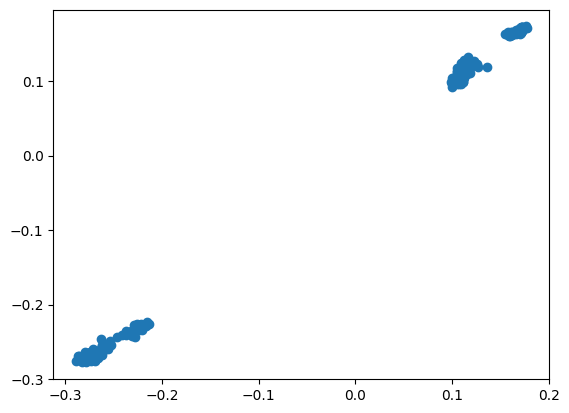

In [25]:
q = model(batches[2])
import matplotlib.pyplot as plt
plt.scatter(ref_charges[2].detach().numpy(),q.detach().numpy())


## Congratulations!

You’ve just built and trained your **first rotationally invariant neural network** for atomistic systems.

From embeddings to message passing and radial filters – this pipeline forms the core of many modern models in computational chemistry and materials science.

<details>
<summary><strong>Where to go from here?</strong> (click)</summary>

- Try training on larger datasets or predicting other atomic/molecular properties.  
- Add angular information for directional interactions (e.g. using spherical harmonics).  
- Implement multiple convolution blocks or skip connections.  
- Compare performance with baseline methods.

</details>

# Equivariant NN - SO3Net 

## Node Embedding

Again, we start by defining an embedding for the elements present in our dataset.  
For this, we can copy the idea from the invariant model.
  
Extract the number of distinct elements from the `BatchedTorchAtoms` object and define an embedding with `feature_dimension=16`.

<details>
<summary><strong>Hint</strong></summary>
What is the input to `nn.Embedding`?
    
You need the number of distinct atomic types (`n_elements`) as first argument, and the embedding dimension (`feature_dimension`) as second.

</details>


In [26]:
n_elements = batched_mols.n_elements
species_types = batched_mols.element_labels
feature_dimension = 16
element_embedding = nn.Embedding(n_elements, feature_dimension)
node_embeddings = element_embedding(species_types)
print(node_embeddings)
print(node_embeddings.shape)

tensor([[ 0.8068,  0.6825,  0.8130,  ...,  1.3497, -1.0661,  0.9462],
        [-0.6554, -0.6167, -0.3515,  ...,  0.9679,  1.6638, -1.5025],
        [-0.6554, -0.6167, -0.3515,  ...,  0.9679,  1.6638, -1.5025],
        ...,
        [ 0.8068,  0.6825,  0.8130,  ...,  1.3497, -1.0661,  0.9462],
        [-0.6554, -0.6167, -0.3515,  ...,  0.9679,  1.6638, -1.5025],
        [-0.6554, -0.6167, -0.3515,  ...,  0.9679,  1.6638, -1.5025]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([240, 16])


### Radial Basis & Edge Embedding

Additionally, we again need a radial basis to represent the edge features.  
We will reuse the `SimpleRBF` class from the invariant model.
 
Using `SimpleRBF`, define a radial basis with:
- 10 radial functions (`n_rbf = 10`)
- cutoff radius of `3.0 Å`

<details>
    <summary><strong>Hint</strong></summary>
What’s the input to `SimpleRBF`?
    
You need to specify `n_rbf` and `cutoff`. No need to change the `start` value.

</details>


In [27]:
### This is a reminder cell, no need to reimplement this

class SimpleRBF(nn.Module):
    def __init__(self, n_rbf, cutoff, start=0.0):
        super().__init__()
        offset = torch.linspace(start, cutoff, n_rbf)
        width  = torch.abs(offset[1] - offset[0])
        self.n_rbf = n_rbf
        self.register_buffer("offset", offset)
        self.register_buffer("widths", torch.full_like(offset, width))

    def forward(self, d_ij):
        return torch.exp(-((d_ij.unsqueeze(-1) - self.offset) ** 2) / self.widths)

In [28]:
n_rbf = 10
cutoff = 3.0
RBF = SimpleRBF(n_rbf,cutoff)
edge_embeddings = RBF(d_ij)

print(edge_embeddings.shape)
print(edge_embeddings)

torch.Size([1558, 10])
tensor([[2.1320e-10, 3.5522e-08, 3.0386e-06,  ..., 6.3189e-01, 9.9001e-01,
         7.9637e-01],
        [6.0783e-02, 3.0076e-01, 7.6406e-01,  ..., 3.6706e-03, 1.7079e-04,
         4.0801e-06],
        [6.0807e-02, 3.0084e-01, 7.6416e-01,  ..., 3.6685e-03, 1.7067e-04,
         4.0766e-06],
        ...,
        [2.8709e-05, 8.6100e-04, 1.3258e-02,  ..., 5.2095e-01, 1.4692e-01,
         2.1273e-02],
        [2.4658e-12, 6.9155e-10, 9.9578e-08,  ..., 2.7984e-01, 7.3803e-01,
         9.9931e-01],
        [8.1910e-04, 1.2749e-02, 1.0189e-01,  ..., 1.5077e-01, 2.2068e-02,
         1.6584e-03]])


### Equivariant convolution (SO(3) tensor coupling)

Now comes the critical part that separates **SO3Net** from simpler invariant models like **SchNet**:  
the **equivariant convolution**. This operation couples edge and node features in a way that respects the transformation properties (irreducible representations, or *irreps*) under 3D rotations.

In contrast to invariant convolutions, we must now ensure that **the character of each feature is preserved** throughout the network. This is what enables the model to remain **equivariant under SO(3) transformations**, i.e. to transform predictably under rotations.

We encode the feature types via:

`irrep_l = ["x0e","..."]`

These define the structure of the irreps for the different angular momentum orders `l`, alternating between even/odd parity (`e/o`).

**Convolution workflow**

This convolution works by projecting both node and edge features into a **shared latent space**
and coupling them using spherical harmonics and a **tensor product** (via `e3nn.o3.FullyConnectedTensorProduct`).

We are going to perform the following steps:

1. **Edge MLP projection:**
   Project the edge embeddings (i.e. RBF-expanded distances) through a fully connected layer with activation.
   This transforms them into a suitable filter tensor `W_ij`.

2. **Spherical harmonics computation:**
   Use `e3nn.o3.spherical_harmonics` to encode the directional relation between atoms via `r_ij`.

3. **Tensor product coupling:**
   Perform the tensor product between node features `x_j`, the spherical harmonics, and the filter weights `W_ij`.
   This step is **structure-aware** and **equivariant**.

4. **Aggregation via scatter sum:**
   Aggregate the messages sent to each atom `i` from its neighbors `j` using `scatter_add`.

<details>
<summary><strong>Hint</strong></summary>
Why spherical harmonics?
    
Spherical harmonics serve as a rotational basis for directional interactions.
By combining them with scalar edge features and node features via tensor product, we preserve equivariance.

</details>
<br>
<details>
<summary><strong>Hint</strong></summary>
 Why `FullyConnectedTensorProduct`?
    
This module generalizes matrix multiplication to `SO(3)`-equivariant representations.
It defines how two irreps (e.g. node and direction) can be coupled into an output irrep.

</details>
<br>
<details>
<summary><strong>Task</strong>

Implement an equivariant convolution module with the following interface: *(click to expand)* </summary>

- **Constructor inputs:**

  * `lmax`: maximum angular momentum of spherical harmonics
  * `feature_dimension`: dimension per irrep block
  * `edge_dimension`: input dimension of edge features
  * `activation`: nonlinearity (e.g. `F.silu`)

- **Forward inputs:**

  * `x`: node features (with irreps defined by `lmax` and `feature_dimension`)
  * `e_ij`: edge features (from RBF)
  * `r_ij`: relative position vectors
  * `idx_i`, `idx_j`: indices of atom pairs for message passing

- **Steps in `forward`:**

  * Compute spherical harmonics `Y_lm(r_ij)` using `o3.spherical_harmonics`
  * Use an MLP (`Linear + activation`) on `e_ij` to get filter weights `W_ij`
  * Apply a tensor product `x_j ⊗ Y_lm ⊗ W_ij` to compute messages
  * Aggregate messages for each target atom `i` via `scatter_add`

</details>

In [29]:
irrep_l = ["x0e","x1o","x2e","x3o","x4e"] 

class EquivariantConvolution(nn.Module):
    def __init__(self, 
                 lmax,
                 feature_dimension, 
                 edge_dimension, 
                 activation=F.silu):
        super(EquivariantConvolution, self).__init__()
        self.lmax = lmax

        # Prepare the irreducible representations
        self.irreps_sh = o3.Irreps.spherical_harmonics(lmax=lmax)
        irrep_string = f"{feature_dimension}{irrep_l[0]}"
        for l in range(lmax):
            irrep_string += f" + {feature_dimension}{irrep_l[l+1]}"
        self.irreps_x  = o3.Irreps(irrep_string)
        
        # Define the tensor product and other neural network components
        self.tp = o3.FullyConnectedTensorProduct(irreps_in1=self.irreps_x, 
                                                 irreps_in2=self.irreps_sh, 
                                                 irreps_out=self.irreps_x, 
                                                 shared_weights=False)

        self.edge2filter = nn.Linear(edge_dimension, self.tp.weight_numel)
        self.act = activation
        
    def forward(self,
                x,
                e_ij,
                r_ij,
                idx_i,
                idx_j):

        ylm = o3.spherical_harmonics(self.irreps_sh, r_ij, normalize=True, normalization='component')

        Wij = self.act(self.edge2filter(e_ij))

        x_j  = x[idx_j]
        x_ij = self.tp(x_j,ylm,Wij)

        x = scatter_add(x_ij, idx_i, dim=0)
        return x

Now, using your `EquivariantConvolution`-class, define a convolution with a `feature_dimension` of 16 and `lmax` of 1.

In [30]:
eq_conv = EquivariantConvolution(
    lmax=1,
    feature_dimension=feature_dimension,# As defined above
    edge_dimension=RBF.n_rbf
)

/home/mvondrak/.pyenv/versions/3.9.19/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


## A first equivariant network

### Scalar-to-irrep expansion

Before feeding scalar node embeddings into an `SO(3)`-equivariant network,  
we need to lift them into the appropriate tensor shape for spherical harmonic coupling.

Build a helper function that expands a `[N_atoms, N_features]` tensor into a padded form matching  
the irreducible representation structure up to angular momentum `lmax`.

<details>
<summary><strong>Hint</strong></summary>
 Why pad with zeros?
    
The initial node features are scalars (`l=0`). To match the full SO(3) structure,  
we zero-pad the higher-`l` components before further equivariant processing.

</details>


In [31]:
def expand_scalar_tensor(x: torch.Tensor, lmax: int) -> torch.Tensor:
    """
    Expand scalar tensor to spherical harmonics shape with angular momentum up to `lmax`

    Args:
        x: tensor of shape [N_atoms, N_features]
        lmax: maximum angular momentum

    Returns:
        zero-padded tensor to shape [N_atoms, (lmax+1)^2*N_features]
    """
    x = x.unsqueeze(1)
    
    y = torch.cat(
        [
            x,
            torch.zeros(
                (x.shape[0], int((lmax + 1) ** 2 - 1), x.shape[2]),
                device=x.device,
                dtype=x.dtype,
            ),
        ],
        dim=1,
    )
    return torch.reshape(y,(x.shape[0],(lmax+1)**2*x.shape[2]))

### Simple `SO(3)`-equivariant neural network

This model implements a basic `SO(3)`-equivariant message passing network using irreducible representations.

The architecture:

- Embeds atoms as scalars (`l=0`) and expands them to match a full SO(3) irrep structure (via `expand_scalar_tensor`)
- Represents directional edge information via spherical harmonics and RBFs
- Applies several rounds of equivariant convolutions (with `l ≤ lmax`)
- Predicts a vector-valued property (e.g. molecular dipole) using an equivariant linear readout (`l=1`)

<details>
<summary><strong>Hint</strong></summary>
    
 Why `1x1o` for the readout?

Dipole moments are 3D vectors. In `SO(3)` terms, these transform like `l=1` irreps with odd parity (`1o`).

</details>


In [32]:
class SimpleEqNet(nn.Module):
    """
    A simple SO3-equivariant representation 
    """
    def __init__(
        self,
        feature_dimension,
        lmax,
        n_interactions, 
        radial_basis,
        n_elements, 
        activation = F.silu
    ):
        """
        Args:
            feature_dimension: number of features to describe atomic environments.
                This determines the size of each embedding vector; i.e. embeddings_dim.
            n_interactions: number of interaction blocks.
            lmax: maximum angular momentum of spherical harmonics basis
            radial_basis: layer for expanding interatomic distances in a basis set
            activation:
        """
        super(SimpleEqNet, self).__init__()

        self.feature_dimension = feature_dimension
        self.lmax = lmax
        self.hidden_irreps = o3.Irreps(f"{self.feature_dimension}x0e+{self.feature_dimension}x1o") # works only for lmax = 1
        self.n_interactions = n_interactions
        self.radial_basis = radial_basis
        self.edge_dimension = radial_basis.n_rbf
        self.activation = activation
        
        # initialize embeddings
        self.embedding = nn.Embedding(n_elements, feature_dimension)

        # initialize equivariant convolution
        self.equconv  = EquivariantConvolution(self.lmax,
                                               self.feature_dimension,
                                               self.edge_dimension,
                                               )
        
        self.dipole_out = o3.Irreps("1x1o")
        self.dipoles_read = o3.Linear(irreps_in=self.hidden_irreps, irreps_out=self.dipole_out)


    def forward(self, inputs: BatchedTorchAtoms):
        """
        Compute atomic representations/embeddings.

        Args:
            inputs (dict of torch.Tensor): torchAtoms with input tensors.

        Returns:
            torch.Tensor: atom-wise representation.
        """
        # get tensors from input 
        species_types = inputs.element_labels
        r_ij = inputs.r_ij
        d_ij = inputs.d_ij
        dir_ij = inputs.dir_ij
        idx_i = inputs.idx_i
        idx_j = inputs.idx_j

        # Radial embedding
        e_ij = self.radial_basis(d_ij)

        # Node embedding
        x = self.embedding(species_types)
        x = expand_scalar_tensor(x,self.lmax)

        # Message passing
        for t in range(self.n_interactions):
            dx = self.equconv(x, e_ij, r_ij, idx_i, idx_j)
            x = x + dx
        
        # Read out
        dipoles = self.dipoles_read(x)
        total_dipole = scatter_sum( # stolen from mace
            src=dipoles,
            index=inputs.mol_id,
            dim=0,
            dim_size=inputs.n_mols,
        )
        return total_dipole

### Training your first equivariant NN



**Dipole prediction with equivariant GNN**

We now train the equivariant network to predict the **total molecular dipole**  
from atom-wise representations, aggregated via equivariant readout.

Now, build the training loop by correctly passing the reference dipole into the loss function.  

<details>
<summary><strong> Hint</strong></summary>

Use `loss = F.mse_loss(dip, reference_dipole)`, since we want to train on the dipoles.

The current setup processes a single molecule as one batch.  
For multiple systems, per-molecule dipoles would need to be computed and compared individually - cf. the batched invariant NN training above.

</details>

In [33]:
n_elements = batched_mols.n_elements
lmax = 1
feature_dimension = 16
gnn = SimpleEqNet(feature_dimension,lmax,3,RBF,n_elements)

/home/mvondrak/.pyenv/versions/3.9.19/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/mvondrak/.pyenv/versions/3.9.19/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


### Increasing the body order: Tensor Product, Mixing and Gating

To move from a simple equivariant message passing network to a **fully expressive SO(3)Net-like architecture**,  
we need to increase the **body order** and model more complex local geometric interactions.

This is achieved through the following additions:

1. A **mixing layer** that prepares node features for interaction
2. A **tensor product** that increases the body order (e.g. from 2-body to 3-body terms)
3. A **gating mechanism** that enables non-linear interactions for higher-order irreps
4. Additional **mixing layers** before and after gating

<details>
<summary><strong>Architecture overview</strong> (click to expand)</summary>

Each interaction block now proceeds through:

- **Equivariant convolution**: Couples neighbors via direction-aware message passing
- **Linear mixing**: Prepares node features for interaction
- **Tensor product**: Increases local body order (e.g. captures angular correlations)
- **Gate**: Applies scalar-controlled nonlinearity to non-scalar features
- **Residual update**: Adds processed message to current node state
</details>

<details>
    <summary><strong>Hint</strong></summary>

What is “body order”?

The body order describes how many atoms interact simultaneously in a feature.  
E.g., standard message passing is 2-body (central atom + neighbor),  
while tensor product can model 3-body or higher interactions (center + 2 neighbors, angular structures).

</details>

<details>
<summary><strong>Hint</strong></summary>
    
What does the gate do?

Scalars are passed through a nonlinearity (e.g. sigmoid) and used to modulate the amplitudes  
of higher-order (vector/tensor) components. This enables non-linear equivariant processing.

</details>

This network retains full SO(3)-equivariance and is expressive enough for vector- and tensor-valued predictions.  
Here, the readout produces a dipole vector (`1×1o`) as the final molecular property.


In [34]:
class EqNet(nn.Module):
    """
    A more involved SO3-equivariant representation 
    """
    def __init__(
        self,
        feature_dimension,
        lmax,
        n_interactions, 
        radial_basis,
        n_elements, 
        activation = F.silu
    ):
        """
        Args:
            feature_dimension: number of features to describe atomic environments.
                This determines the size of each embedding vector; i.e. embeddings_dim.
            n_interactions: number of interaction blocks.
            lmax: maximum angular momentum of spherical harmonics basis
            radial_basis: layer for expanding interatomic distances in a basis set
            activation:
        """
        super(EqNet, self).__init__()

        self.feature_dimension = feature_dimension
        self.lmax = lmax
        self.hidden_irreps = o3.Irreps(f"{self.feature_dimension}x0e+{self.feature_dimension}x1o") # works only for lmax = 1
        self.n_interactions = n_interactions
        self.radial_basis = radial_basis
        self.edge_dimension = radial_basis.n_rbf
        self.activation = activation
        
        # initialize embeddings
        self.embedding = nn.Embedding(n_elements, feature_dimension)

        # initialize linear mixing layers
        # self.linear = nn.Linear(feature_dimension, feature_dimension, bias=False)

        # initialize equivariant convolution
        self.equconv  = EquivariantConvolution(self.lmax,
                                               self.feature_dimension,
                                               self.edge_dimension,
                                               )
        
        # initialize mixing before the tensor product
        self.mixing_to_tp = o3.Linear(irreps_in=self.hidden_irreps,irreps_out=self.hidden_irreps)

        # initialize the tensor product
        self.tp = o3.FullyConnectedTensorProduct(irreps_in1=self.hidden_irreps, irreps_in2=self.hidden_irreps, irreps_out=self.hidden_irreps,internal_weights=False)
        
        # separate the scalar features from the non-scalar features based on Irrep.l
        irreps_scalars = o3.Irreps(
            [(mul, ir) for mul, ir in self.hidden_irreps if ir.l == 0]
        )
        irreps_gated = o3.Irreps(
            [(mul, ir) for mul, ir in self.hidden_irreps if ir.l > 0]
        )
        
        # define an additionally needed amount of scalar features
        irreps_gates = o3.Irreps([mul, "0e"] for mul, _ in irreps_gated)

        # initialize the gating
        self.gating = Gate(
            irreps_scalars=irreps_scalars,
            act_scalars=[torch.sigmoid],
            irreps_gates=irreps_gates,
            act_gates=[torch.sigmoid],
            irreps_gated=irreps_gated
        )

        # define the total amount of irreps for the nonlinearity 
        self.irreps_nonlin = self.gating.irreps_in.simplify()

        # initialize mixing layers before and after the gating
        self.mixing_to_gate = o3.Linear(irreps_in=self.hidden_irreps,irreps_out=self.irreps_nonlin)
        self.mixing_to_read = o3.Linear(irreps_in=self.hidden_irreps,irreps_out=self.hidden_irreps)

        # initialize the readout
        self.dipole_out = o3.Irreps("1x1o")
        self.dipoles_read = o3.Linear(irreps_in=self.hidden_irreps, irreps_out=self.dipole_out)


    def forward(self, inputs: BatchedTorchAtoms):
        """
        Compute atomic representations/embeddings.

        Args:
            inputs (dict of torch.Tensor): torchAtoms with input tensors.

        Returns:
            torch.Tensor: atom-wise representation.
        """
        # get tensors from input 
        species_types = inputs.element_labels
        r_ij = inputs.r_ij
        d_ij = inputs.d_ij
        dir_ij = inputs.dir_ij
        idx_i = inputs.idx_i
        idx_j = inputs.idx_j

        # Radial embedding
        e_ij = self.radial_basis(d_ij)

        # Node embedding
        x = self.embedding(species_types)
        x = expand_scalar_tensor(x,self.lmax)

        for t in range(self.n_interactions):
            # Apply convolution
            dx = self.equconv(x, e_ij, r_ij, idx_i, idx_j)
            # Prepare the features for tensor product
            ddx = self.mixing_to_tp(dx)
            # Apply the tensor product
            dx = dx + self.tp(dx, ddx,torch.ones(self.tp.weight_numel))
            # Prepare the features for the gating
            dx = self.mixing_to_gate(dx)
            # Apply the gating
            dx = self.gating(dx)
            # Recover original dimension
            dx = self.mixing_to_read(dx)
            # Update node representation
            x = x + dx
        dipoles = self.dipoles_read(x)
        # print("dipoles",dipoles.shape)
        total_dipole = scatter_sum( # stolen from mace
            src=dipoles,
            index=inputs.mol_id,
            dim=0,
            dim_size=inputs.n_mols,
        )
        return total_dipole

### Training your fancy equivariant NN

We now train the full SO(3)-equivariant network to predict the molecular **dipole vector**  
based on the atom-wise learned features and directional message passing.

Your job: Provide a complete training loop once more.

<details>
    <summary><strong>Hint</strong></summary>
    
    You'll have to 
- get `n_elements`
- set `lmax` and `feature_dimension`
- instantiate the an `EqNet` object
- read molecule data and use `TorchAtoms` resp. `BatchedTorchAtoms`
- make sure you have the training information (`ref_dipole`) as a correctly shaped `torch.tensor`
</details>

In [35]:
n_elements = batched_mols.n_elements
lmax = 1
feature_dimension = 16
# gnn = SimpleEqNet(feature_dimension,lmax,3,RBF,n_elements)
gnn = EqNet(feature_dimension,lmax,3,RBF,n_elements)

/home/mvondrak/.pyenv/versions/3.9.19/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/mvondrak/.pyenv/versions/3.9.19/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/mvondrak/.pyenv/versions/3.9.19/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warn

In [36]:
mols = read("waterAims.xyz@:10",format="extxyz")
torch_mols = [TorchAtoms(mol) for mol in mols]
batched_mols = BatchedTorchAtoms(torch_mols)

ref_dipole = []
# print(mols[0].info)
for mol in mols:
    ref_dipole.append(mol.info["dft_dipole"])
ref_dipole = torch.tensor(ref_dipole,dtype=torch.float32)
print(ref_dipole.shape)


torch.Size([10, 3])


/tmp/ipykernel_78252/1126341311.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  ref_dipole = torch.tensor(ref_dipole,dtype=torch.float32)


Now, after setting up everything, get the optimizer running in a training `for`-loop.

<details>
    <summary><strong>Hint</strong></summary>
    Basically the same as for the invariant network.
    
    Call the `forward`-method of your `EqNet`-object, calculate loss and don't forget to handle the gradient correctly!
    
</details>

In [37]:
optimizer = torch.optim.AdamW(gnn.parameters(), lr=1e-3)
n_epochs = 200
for epoch in range(n_epochs):
    #gnn.train()
    dip     = gnn(batched_mols)
    # print("d",dip.shape)
    loss  = F.mse_loss(dip, ref_dipole)
    # print(q.,reference_charges.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Finally again, plot as a scatter plot once more.

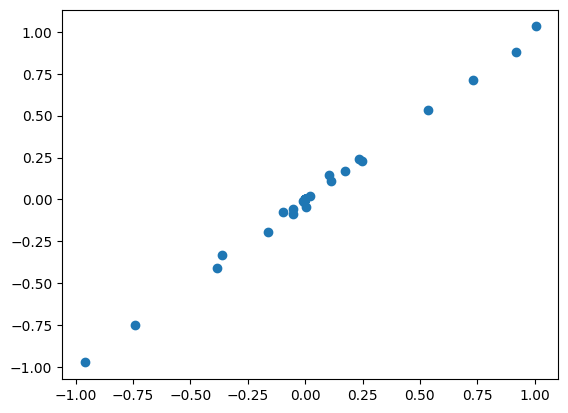

In [38]:
import matplotlib.pyplot as plt
plt.scatter(ref_dipole.detach().numpy(),dip.detach().numpy())

### Rotation equivariance test

To verify that our network is truly `SO(3)`-equivariant, we compare its output on a molecule before and after a rigid rotation.

Define a `rotation` function using `numpy.ndarray`'s.

<details>
<summary><strong>Hint</strong> What should hold if the network is equivariant?</summary>

The predicted dipole after rotation should match the **rotated version** of the original prediction.
    
Steps:

- Select a molecule (`i_mol`)
- Predict dipole from original structure
- Rotate the molecule around a chosen axis
- Predict dipole again and compare with the rotated reference dipole

</details>
<br>

Afterwards, take a molecule and use your `EqNet`-object. Test before and after rotation - what should happen? And what happens?

In [39]:
import numpy as np
def rotate_vector(v, axis, angle_rad):
    axis = axis / np.linalg.norm(axis)  # normalize rotation axis
    cos_theta = np.cos(angle_rad)
    sin_theta = np.sin(angle_rad)
    one_minus_cos = 1 - cos_theta
    x, y, z = axis

    # Rodrigues' rotation matrix
    R = np.array([
        [cos_theta + x*x*one_minus_cos,      x*y*one_minus_cos - z*sin_theta, x*z*one_minus_cos + y*sin_theta],
        [y*x*one_minus_cos + z*sin_theta,    cos_theta + y*y*one_minus_cos,   y*z*one_minus_cos - x*sin_theta],
        [z*x*one_minus_cos - y*sin_theta,    z*y*one_minus_cos + x*sin_theta, cos_theta + z*z*one_minus_cos  ]
    ])

    return R @ v

In [40]:
from copy import deepcopy

i_mol = 9

mol_orig = deepcopy(mols[i_mol])
pred_orig_vector = gnn(BatchedTorchAtoms([TorchAtoms(mol_orig)])).tolist()
rot_vec = rotate_vector(np.array(ref_dipole[i_mol,:]),(0,1,0),np.radians(32))
mol_rots = deepcopy(mols[i_mol])
mol_rots.rotate(32,(0,1,0))
pred_rot_vector = gnn(BatchedTorchAtoms([TorchAtoms(mol_rots)])).tolist()

print(ref_dipole[i_mol,:])
print(pred_orig_vector)

print(rot_vec)
print(pred_rot_vector)

tensor([ 0.2460, -0.0517, -0.0959])
[[0.22734719514846802, -0.08436277508735657, -0.07286977767944336]]
[ 0.15782755 -0.05170073 -0.21165925]
[[0.15418612957000732, -0.08436238765716553, -0.1822723150253296]]


### Congratulations – you just trained your first fully SO(3)-equivariant neural network!

You've now built a message-passing model that respects 3D geometry **by design**:  
From scalar embeddings to equivariant convolutions, tensor products and gating –  
this architecture forms the basis for state-of-the-art models in molecular and materials machine learning.

<details>
<summary><strong>What’s next?</strong> (click me)</summary>

- Predict forces, multipoles or energies using the same architecture  
- Explore higher `lmax` values or more interaction layers  
- Train on diverse molecular datasets (QM9, MD17, SPICE, ...)  
- Benchmark against SchNet, DimeNet, or GemNet

</details>

_Equivariance is not a trick – it's a symmetry principle. And you’ve just made it learnable._
